# Collaboration and Competition

---

### 1. Start the Environment

We begin by importing the necessary packages. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", no_graphics = True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Developing and Training a Model

- Describe the model (citation, in and outputs, architecture, training setup)

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from scripts.DDPG_agent import MADDPG
import torch
from collections import deque
from matplotlib import pyplot as plt

In [7]:

agent = MADDPG(seed=2, noise_start=0.5, update_every=2, gamma=1, t_stop_noise=30000)
n_episodes = 6000
max_t = 1000
scores = []
scores_deque = deque(maxlen=100)
scores_avg = []

for i_episode in range(1, n_episodes+1):
    rewards = []
    env_info = env.reset(train_mode=False)[brain_name]    # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)

    # loop over steps
    for t in range(max_t):
        # select an action
        action = agent.act(state)
        # take action in environment and set parameters to new values
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        rewards_vec = env_info.rewards
        done = env_info.local_done
        # update and train agent with returned information
        agent.step(state, action, rewards_vec, next_state, done)
        state = next_state
        rewards.append(rewards_vec)
        if any(done):
            break

    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
    scores.append(episode_reward)             # save most recent score to overall score array
    scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
    current_avg_score = np.mean(scores_deque)
    scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
    print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score),end="")
    
    # log average score every 200 episodes
    if i_episode % 200 == 0:
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score))
        agent.save_agents(folder='saved_weights', name='ddpg')

    # break and report success if environment is solved
    if np.mean(scores_deque)>=.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        agent.save_agents(folder='saved_weights', name='ddpg')
        break

Episode 200	Average Score: 0.004
Episode 400	Average Score: 0.003
Episode 600	Average Score: 0.019
Episode 800	Average Score: 0.015
Episode 1000	Average Score: 0.024
Episode 1200	Average Score: 0.076
Episode 1400	Average Score: 0.081
Episode 1600	Average Score: 0.130
Episode 1800	Average Score: 0.100
Episode 2000	Average Score: 0.106
Episode 2200	Average Score: 0.282
Episode 2400	Average Score: 0.356
Episode 2600	Average Score: 0.169
Episode 2800	Average Score: 0.167
Episode 3000	Average Score: 0.188
Episode 3200	Average Score: 0.144
Episode 3400	Average Score: 0.410
Episode 3600	Average Score: 0.178
Episode 3800	Average Score: 0.238
Episode 4000	Average Score: 0.195
Episode 4200	Average Score: 0.206
Episode 4400	Average Score: 0.291
Episode 4600	Average Score: 0.178
Episode 4800	Average Score: 0.151
Episode 5000	Average Score: 0.240
Episode 5200	Average Score: 0.323
Episode 5400	Average Score: 0.406
Episode 5594	Average Score: 0.510
Environment solved in 5594 episodes!	Average Score: 

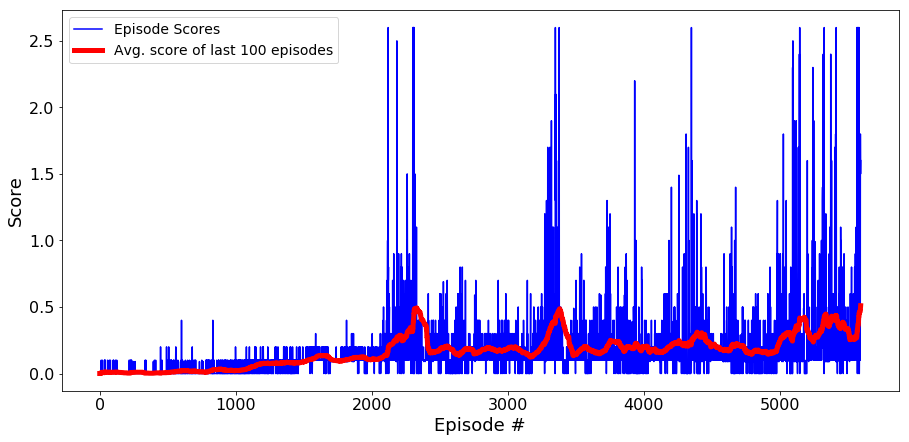

In [8]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'b',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), scores_avg,'r',\
         linewidth=5,label='Avg. score of last 100 episodes')
plt.ylabel('Score', fontsize=18)
plt.xlabel('Episode #', fontsize=18)
ax.legend(fontsize=14)
plt.savefig('MADDPG_learning_curve.png')

In [9]:
env.close()